# Predicting Social Mobility using Cross Validation and Random Forests

## Methods/Concepts: random forests, cross validation

# Setting up the environment


In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle

pd.options.display.max_columns = None

In [2]:
import os
os.getcwd()

'/Users/anku/Downloads/社會科學資料分析與大數據 （stata)/9. Cross Validation  Random Forest-20250512'

In [ ]:
os.chdir(' ')

### Read in the Training Data and Lock Box Data



In [10]:
train_data = pd.read_stata("atlas_training.dta")
test_data = pd.read_stata("atlas_lockbox.dta")

In [12]:
print('The training data has', train_data.shape[0], 'rows and', train_data.shape[1], 'columns')
print('The test data has', test_data.shape[0], 'rows and', test_data.shape[1], 'columns')

The training data has 2518 rows and 128 columns
The test data has 2518 rows and 2 columns


### Define y_train, y_test, X_train, and X_test. 



In [13]:
test_geoids = train_data[train_data.test == 1].geoid
training_geoids = train_data[train_data.training == 1].geoid

In [14]:
all_predictors = [col for col in train_data if col.startswith('P_')]
X_train = train_data[train_data.training == 1][all_predictors]
X_test = train_data[train_data.test == 1][all_predictors]

In [15]:
y_train = pd.DataFrame(train_data[train_data.training == 1].kfr_pooled_pooled_p25)
y_test = pd.DataFrame(test_data[test_data.geoid.isin(test_geoids)].kfr_actual)

In [16]:
print('y_test:', y_test.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('X_train:', X_train.shape)

y_test: (1259, 1)
y_train: (1259, 1)
X_test: (1259, 121)
X_train: (1259, 121)


# Question 3: Cross-Validation Loop



In [17]:
hand_selected_predictors = ['P_34', 'P_57'] 
print("Number of items in the list = ", len(hand_selected_predictors))

Number of items in the list =  2


In [18]:
folds = 5
ID = 1234
kf = KFold(n_splits=folds, random_state=ID, shuffle=True)

In [19]:
#The loop takes as an input the number of predictors
predictors_num = len(hand_selected_predictors)

## Set a range of tree depths
depths = np.arange(1,21)
test_rmse = []

## Iterate over the range of depths
for depth in depths:
    
    # Create decision tree model of depth size 'depth'
    tree = DecisionTreeRegressor(max_depth=depth)
    fold_rmse = []
    
    # Split test data by fold
    for train_index, test_index in kf.split(X_train):
        
        # Create X and Y objects for folds used to fit the model
        fold_xtrain = X_train.iloc[train_index][hand_selected_predictors].values.reshape(-1,predictors_num)
        fold_ytrain = y_train.iloc[train_index]
        
        # Create X and Y objects for the fold left out
        fold_xtest = X_train.iloc[test_index][hand_selected_predictors].values.reshape(-1,predictors_num)
        fold_ytest = y_train.iloc[test_index]

        # Fit the decision tree on the training folds
        dtreemodel = tree.fit(fold_xtrain, fold_ytrain) 

        # Use that model to predict values for the fold left out and calculate the RMSPE
        test_pred = tree.predict(fold_xtest)
        test_sqrt = np.sqrt(mean_squared_error(fold_ytest, test_pred))
        fold_rmse.append(test_sqrt)   
    
    # Take the mean RMSE across all folds for that depth
    test_rmse.append(np.mean(fold_rmse))

## Question 3a: Plot Cross Validation RMSPE


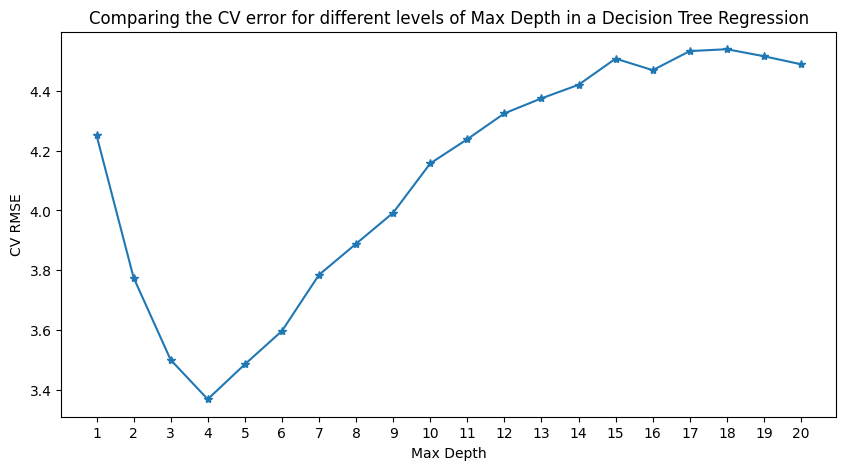

In [20]:
plt.figure(figsize=(10,5))
plt.plot(depths, test_rmse, '*-')
plt.xlabel('Max Depth')
plt.ylabel('CV RMSE')
plt.xticks(np.arange(min(depths), max(depths)+1, 1.0))
plt.title("Comparing the CV error for different levels of Max Depth in a Decision Tree Regression")
plt.show()

### Question 3b: Select Depth using Cross Validation


In [21]:
cv_optimal_depth = 4

*Using P_1 and P_2 which are both bankruptcy variables (measured in two different years), I find that the opitmal depth is 3 using the python loop.*

### Question 3c: Estimate and Visualize a Final Tree using Cross Validation Selected Depth


In [22]:
DTREE = DecisionTreeRegressor(max_depth=cv_optimal_depth)
dtreemodel = DTREE.fit(X_train[hand_selected_predictors], y_train) 

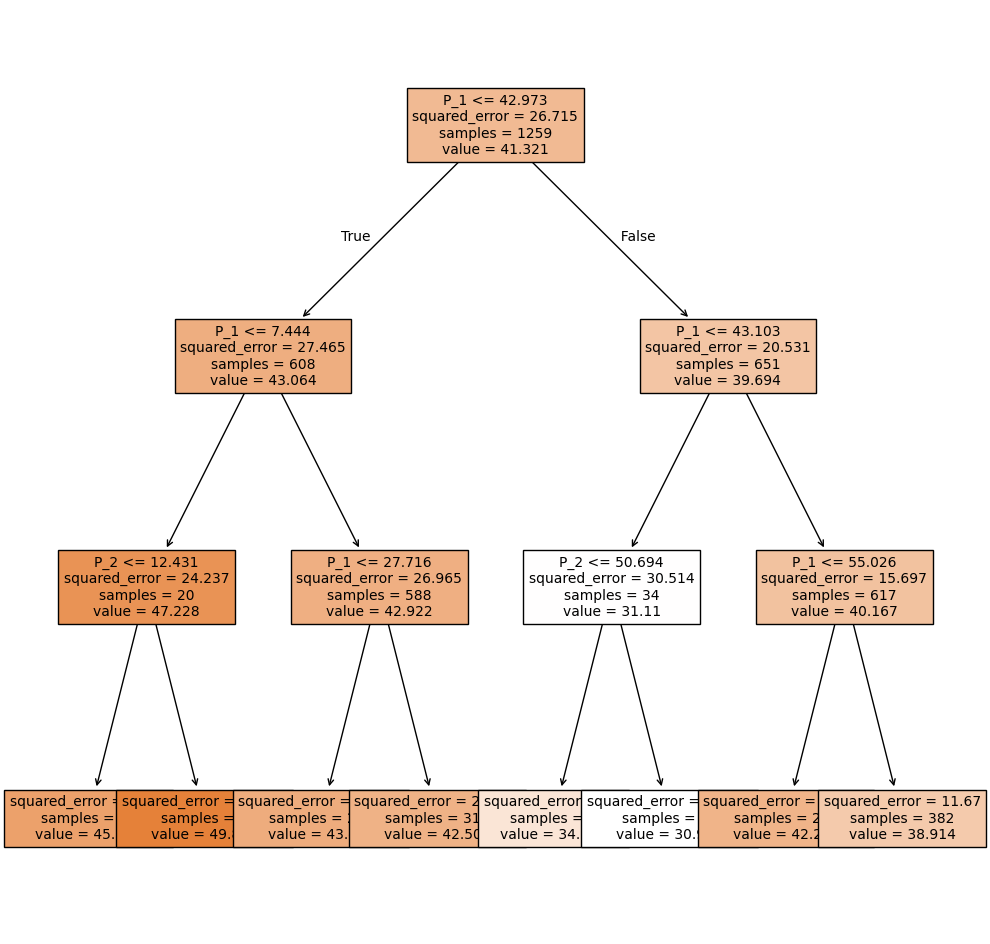

In [19]:
plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
plot_tree(dtreemodel, fontsize=10, feature_names=hand_selected_predictors, filled=True)
plt.show()

### Question 3d: Predictions in test and training samples

In [23]:
y_train_predictions_tree = dtreemodel.predict(X_train[hand_selected_predictors])
y_test_predictions_tree = dtreemodel.predict(X_test[hand_selected_predictors])

In [24]:
tree_num = 500
predictors_num = 2
rforest_small = RandomForestRegressor(n_estimators=tree_num, max_features=predictors_num)

In [25]:
RForestSmallModel = rforest_small.fit(X_train[hand_selected_predictors], y_train.values.ravel())

In [26]:
y_train_predictions_small_forest = RForestSmallModel.predict(X_train[hand_selected_predictors])
y_test_predictions_small_forest = RForestSmallModel.predict(X_test[hand_selected_predictors])

In [27]:
tree_num = 500
predictors_num = 30
RForest = RandomForestRegressor(n_estimators=tree_num, max_features=predictors_num)

In [28]:
RForestModel = RForest.fit(X_train, y_train.values.ravel())

In [29]:
y_train_predictions_forest = RForestModel.predict(X_train)
y_test_predictions_forest = RForestModel.predict(X_test)

#Feature Importance

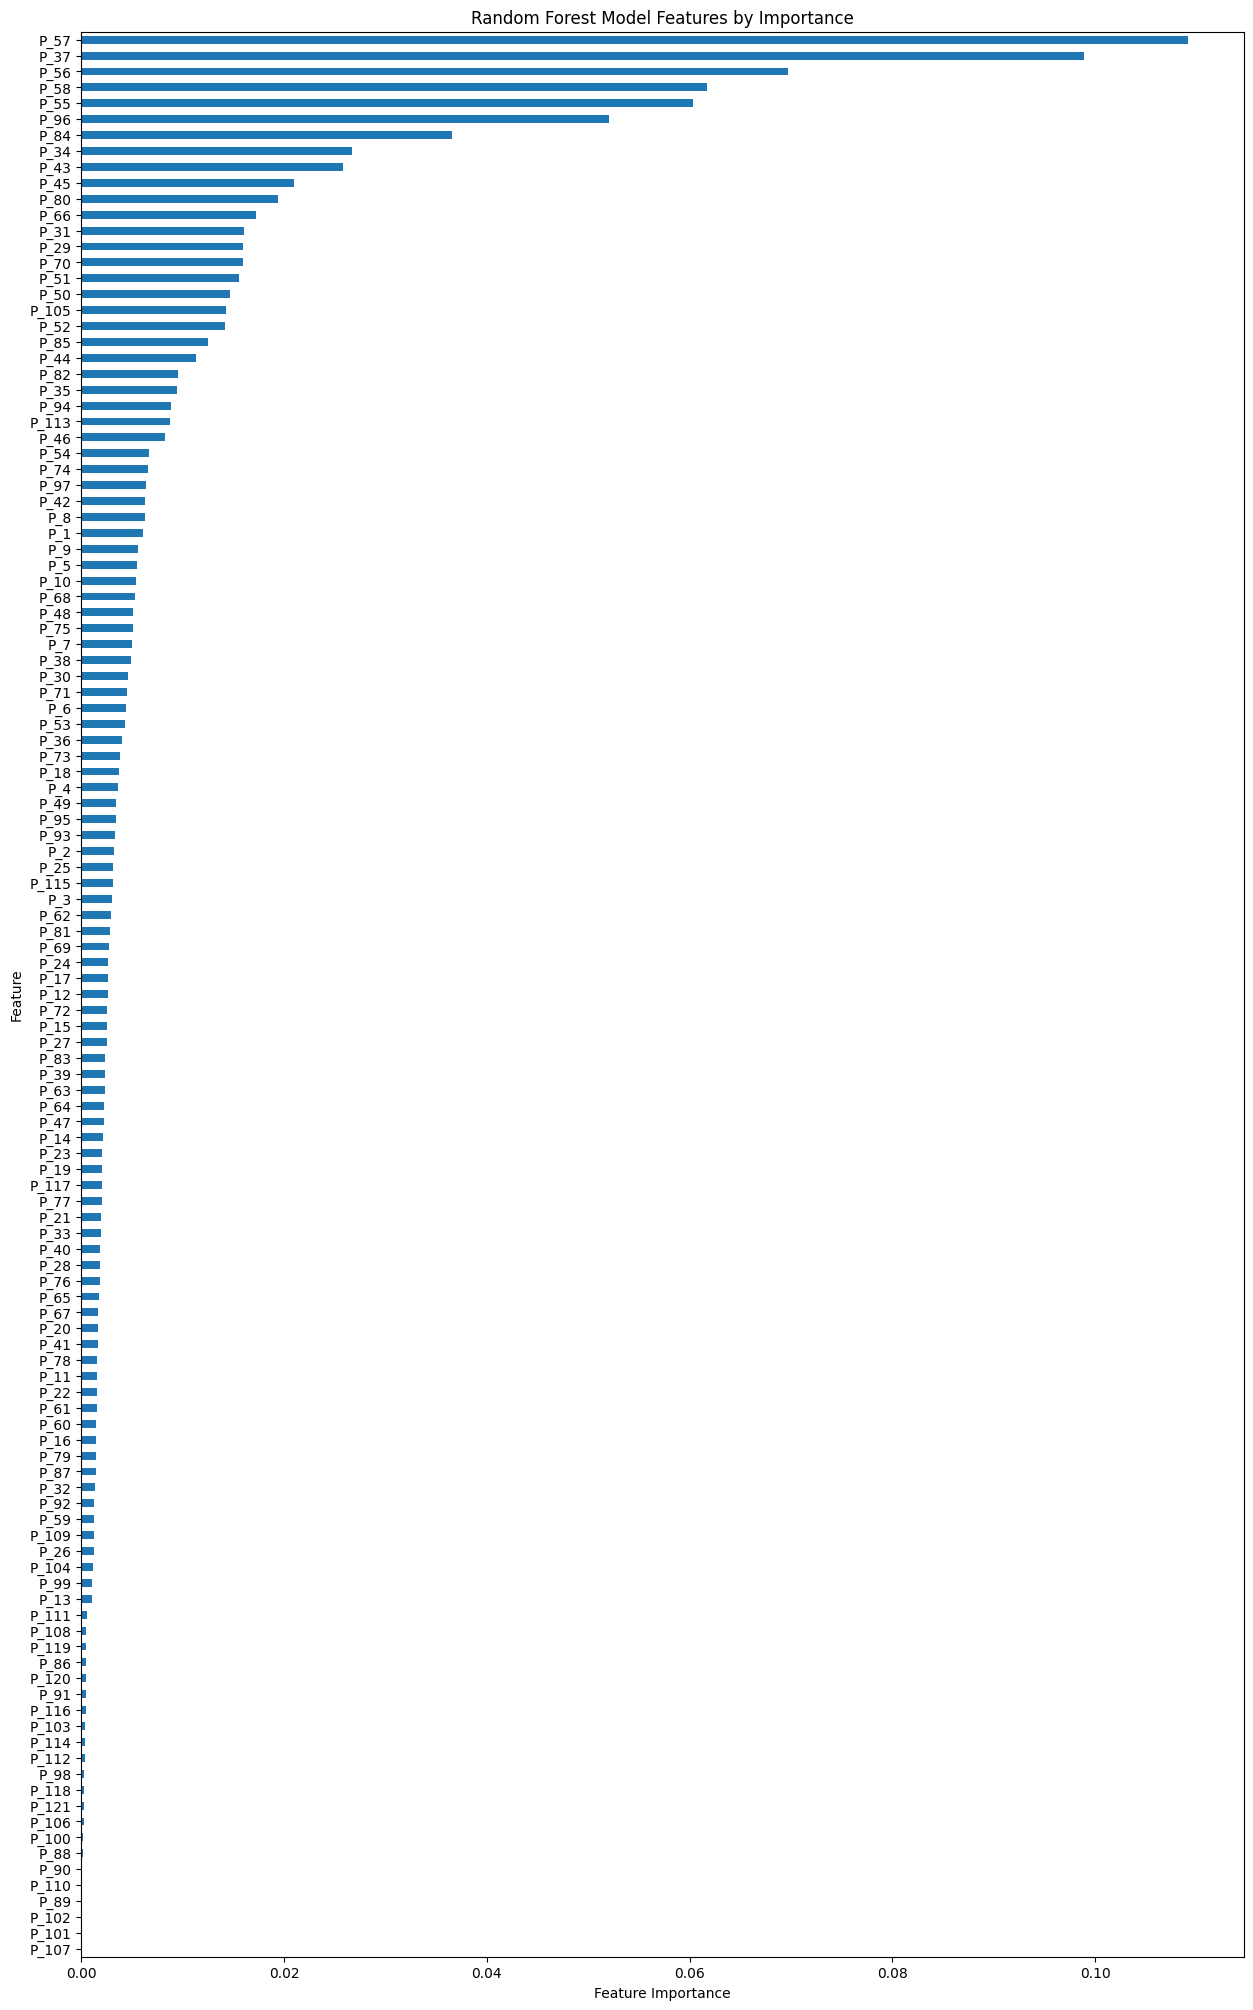

In [27]:
plt.figure(figsize=(15,25))
pd.Series(RForestModel.feature_importances_, index=list(X_train)).sort_values().plot(kind="barh");
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Model Features by Importance');
plt.show()

## Question 8: Performance in Training Data Set

In [30]:
tree_performance_trainset = mean_squared_error(y_train, y_train_predictions_tree)
smallforest_performance_trainset = mean_squared_error(y_train, y_train_predictions_small_forest)
forest_performance_trainset = mean_squared_error(y_train, y_train_predictions_forest)

print('Tree with hand picked predictors', round(np.sqrt(tree_performance_trainset), 4))
print('Random forest with hand picked predictors: ', round(np.sqrt(smallforest_performance_trainset), 4))
print('Random forest with full set of 121 predictors:', round(np.sqrt(forest_performance_trainset), 4))

Tree with hand picked predictors 3.0805
Random forest with hand picked predictors:  1.2825
Random forest with full set of 121 predictors: 0.7996


## Question 9: Performance in Lock Box Data Set

In [31]:
tree_performance_testset = mean_squared_error(y_test, y_test_predictions_tree)
smallforest_performance_testset = mean_squared_error(y_test, y_test_predictions_small_forest)
forest_performance_testset = mean_squared_error(y_test, y_test_predictions_forest)

print('Tree with hand picked predictors', round(np.sqrt(tree_performance_testset), 4))
print('Random forest with hand picked predictors: ', round(np.sqrt(smallforest_performance_testset), 4))
print('Random forest with full set of 121 predictors:', round(np.sqrt(forest_performance_testset), 4))

Tree with hand picked predictors 3.2935
Random forest with hand picked predictors:  3.4191
Random forest with full set of 121 predictors: 2.1863
